Necessary imports
dataset: Represents mutations
model: GNN


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#from src.dataset import MutationDataset
from src.model import *
from torch_geometric.loader import DataLoader
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
import copy
import os
import time

from src.make_dataset import make_dataset_threaded
from torch_geometric.loader import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ExponentialLR
writer = SummaryWriter(log_dir="tensorboard_runs")
os.environ['KMP_DUPLICATE_LIB_OK']='True'

c:\ProgramData\Miniconda3\envs\bioinformatics\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
To use the Graphein submodule graphein.protein.features.sequence.embeddings, you need to install: biovec 
biovec cannot be installed via conda
c:\ProgramData\Miniconda3\envs\bioinformatics\lib\site-packages\pytorch3d\renderer\opengl\__init__.py:16: UserWarning: Can't import EGL, not importing MeshRasterizerOpenGL. This might happen if your Python application imported OpenGL with a non-EGL backend before importing PyTorch3D, or if you don't have pyopengl installed as part of your Python distribution.
  warnings.warn(


In [3]:
make_dataset_threaded(index_xlsx="./renumbered_index.xlsx", root="dataset")

In [5]:
dataset = MutationDataset(index_xlsx="renumbered_index.xlsx", root="dataset_3")
train_size = int(len(dataset)*0.8)
val_size = len(dataset)-train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

In [6]:
print("Length test dataset: ", len(val_loader))
print("Length train dataset: ", len(train_dataset))

Length test dataset:  192
Length train dataset:  765


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ddGPredictor().to(device)
device

'cuda'

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = ExponentialLR(optimizer, gamma=0.9)
loss_fn =  nn.MSELoss()

In [9]:
k = 6
epochs = 1000

model.train()

for epoch in tqdm(range(1, epochs)):
    epoch_loss = 0.
    best_loss = 1000.
    model.train()
    for i, batch in enumerate(train_loader) :
        x, y = batch["mutated"].to(device), batch["non_mutated"].to(device)
        ddg = batch["ddg"].to(device)
        optimizer.zero_grad()
        out = model(x,y)
        loss = loss_fn(out, ddg)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        clear_output(wait=True)
    epoch_loss/=len(train_loader)
    if epoch%5==0:
        scheduler.step()
    writer.add_scalar("RUN_{}/Loss/train".format(k), epoch_loss, epoch+1)

    if epoch%250==0:
        model.eval()
        val_loss = 0
        for i, batch in enumerate(val_loader):
            
            x, y = batch["mutated"].to(device), batch["non_mutated"].to(device)
            ddg = batch["ddg"].to(device)
            out = model(x,y)
            loss = loss_fn(out, ddg)
            val_loss+=loss.item()/len(val_dataset)
        print("Validation loss:", val_loss)
        writer.add_scalar("RUN_{}/Loss/val".format(k), epoch+1, epoch_loss)
    
    if epoch_loss<best_loss:
        best_model = copy.deepcopy(model)
        
        torch.save(model.state_dict(), "model.pt")
    else:
        scheduler.step()
    print("Epoch: {}, Loss: {}".format(epoch+1, epoch_loss))

  3%|▎         | 27/999 [02:24<1:26:44,  5.35s/it]


KeyboardInterrupt: 

In [11]:
model(train_dataset[1]["mutated"].cuda(), train_dataset[1]["non_mutated"].cuda())

tensor([[1.8598]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [12]:
d = next(iter(train_loader))
model(d["mutated"].cuda(), d["non_mutated"].cuda())

tensor([[-0.2798],
        [ 0.2021],
        [ 1.0344],
        [ 2.6076],
        [ 1.3031],
        [ 3.9101],
        [ 1.0974],
        [ 1.1457],
        [ 5.4588],
        [ 0.2456],
        [ 0.9510],
        [ 6.0798],
        [ 0.8791],
        [ 0.3893],
        [ 0.6709],
        [ 3.8383],
        [ 3.5572],
        [ 3.7081],
        [-0.7249],
        [ 0.6769],
        [ 0.0780],
        [-0.0890],
        [ 0.3727],
        [ 0.4143],
        [ 3.4160],
        [ 1.4413],
        [ 1.9495],
        [ 0.5772],
        [ 1.7780],
        [ 0.1001],
        [ 1.3959],
        [ 0.4175],
        [ 1.2683],
        [ 1.3959],
        [ 1.1541],
        [ 0.2657],
        [-0.0331],
        [ 0.7409],
        [ 0.2605],
        [ 2.3306],
        [-1.0508],
        [ 0.1210],
        [ 0.8015],
        [ 1.3041],
        [ 7.3063],
        [-1.0508],
        [ 0.4143],
        [ 2.7045],
        [-0.2636],
        [ 2.6230],
        [ 0.4998],
        [ 1.3959],
        [ 0.

100%|██████████| 190/190 [00:11<00:00, 17.15it/s]


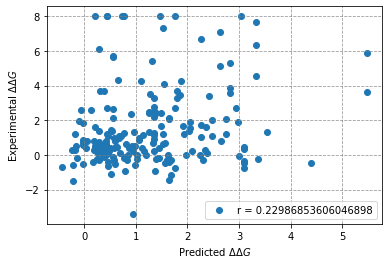

In [21]:
model.load_state_dict(torch.load("model.pt"))
comparator(model, val_dataset, 190, "cuda")

In [20]:
from graphein.protein.graphs import construct_graph
params_to_change = {"granularity": "atom", "edge_construction_functions": [add_atomic_edges, add_bond_order, add_hydrogen_bond_interactions, add_ionic_interactions, add_peptide_bonds]}
config = ProteinGraphConfig(**params_to_change)
graph_mutated = construct_graph(config=config,pdb_path="weighted_dataset/raw/temp/0_mutated_interface.pdb")

Output()

In [4]:
from graphein.protein.visualisation import plotly_protein_structure_graph

p = plotly_protein_structure_graph(
    graph_mutated,
    colour_edges_by="kind",
    colour_nodes_by="element_symbol",
    label_node_ids=False,
    node_size_min=5,
    node_alpha=0.85,
    node_size_multiplier=1,
    plot_title="Atom-level graph. Nodes coloured by their Element"
    )
p.show()

In [48]:
graph_mutated2 = construct_graph(config=config,pdb_path="dataset_3/raw/temp/0_mutated_interface.pdb")
p = plotly_protein_structure_graph(
    graph_mutated2,
    colour_edges_by="kind",
    colour_nodes_by="element_symbol",
    label_node_ids=False,
    node_size_min=5,
    node_alpha=0.85,
    node_size_multiplier=1,
    plot_title="Atom-level graph. Nodes coloured by their Element"
    )
p.show()

Output()

In [25]:
format_convertor = GraphFormatConvertor('nx', 'pyg', verbose="default")


In [26]:
pyg_graph_mutated = format_convertor(graph_mutated)
from graphein.protein.edges.distance import add_hydrogen_bond_interactions, add_ionic_interactions, add_peptide_bonds
#config = ProteinGraphConfig()


# Create backbone graph with additional interactions
#edge_funcs = [add_hydrogen_bond_interactions, add_ionic_interactions, add_peptide_bonds]

#c#onfig = ProteinGraphConfig(edge_construction_functions= edge_funcs)
from graphein.protein.edges.distance import compute_distmat
##graph_mutated = construct_graph(config=config,pdb_path="dataset/raw/temp/0_mutated_interface.pdb")



In [22]:
dist_mat = compute_distmat(graph_mutated.graph["pdb_df"])
dist_mat

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,0.000000,1.463077,2.473193,2.924231,2.461375,3.793523,2.891507,3.494277,4.735772,5.911617,...,18.234528,18.563423,17.403223,16.339660,17.584510,17.768251,16.870311,17.596775,16.185633,15.487925
1,1.463077,0.000000,1.513641,2.370504,1.537101,2.508547,2.426412,2.436403,3.794810,4.740376,...,17.156907,17.491136,16.312993,15.243305,16.460804,16.566168,15.630824,16.514226,15.123125,14.441520
2,2.473193,1.513641,0.000000,1.223965,2.445232,2.817392,3.717415,1.328303,2.412034,3.524934,...,17.541750,17.951320,16.794043,15.455512,16.590764,16.602976,15.607888,16.583858,15.188567,14.634144
3,2.924231,2.370504,1.223965,0.000000,2.906975,3.327529,4.260692,2.238375,2.721696,3.914191,...,17.848309,18.349994,17.256058,15.597322,16.693681,16.740889,15.754828,16.575053,15.150703,14.687359
4,2.461375,1.537101,2.445232,2.906975,0.000000,1.508454,1.431820,3.415262,4.626160,5.293501,...,15.851722,16.235453,15.108130,13.892717,15.127536,15.310745,14.420616,15.147246,13.743654,13.046113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,17.768251,16.566168,16.602976,16.740889,15.310745,14.065554,15.327841,16.630581,16.825146,15.857531,...,4.064770,5.303395,5.582486,2.470251,1.521047,0.000000,1.233066,2.529177,3.252607,3.473427
88,16.870311,15.630824,15.607888,15.754828,14.420616,13.128801,14.508180,15.584889,15.733628,14.728027,...,4.795394,5.910589,5.890227,2.821423,2.401871,1.233066,0.000000,3.160040,3.381715,3.565853
89,17.596775,16.514226,16.583858,16.575053,15.147246,14.036072,15.142580,16.800651,17.031393,16.232717,...,4.836090,6.326429,6.794181,2.345319,1.522438,2.529177,3.160040,0.000000,1.486209,2.378306
90,16.185633,15.123125,15.188567,15.150703,13.743654,12.656452,13.763514,15.447924,15.692147,14.949560,...,5.415162,6.844795,7.041202,2.317156,2.378666,3.252607,3.381715,1.486209,0.000000,1.487354


In [27]:
pyg_graph_mutated.edge_index[1, 2]

tensor(4)

In [28]:
dist_mat = dist_mat.to_numpy()

In [46]:
ei = pyg_graph_mutated.edge_index


In [32]:
edge_weights = []
for i in range(ei.shape[1]):
    edge_weights.append(1/dist_mat[ei[0, i].item(), ei[1, i].item()])
w = torch.tensor(edge_weights)

In [43]:
ei.reshape(ei.shape[1], ei.shape[0]).unique(dim =1).shape

torch.Size([181, 2])

In [47]:
torch_geometric.utils.coalesce(ei).shape

torch.Size([2, 181])

In [60]:
from graphein.protein.visualisation import plot_distance_matrix

plot_distance_matrix(graph_mutated)

KeyError: 'dist_mat'

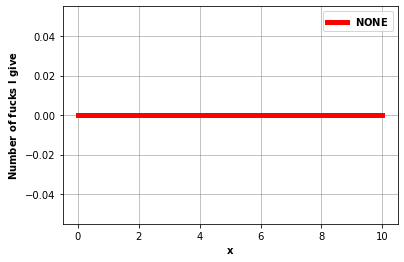

In [38]:
plt.plot([0, 10], [0, 0], label="$\\mathbf{NONE}$", c="r", linewidth=5)
plt.xlabel("$\\mathbf{x}$")
plt.ylabel("$\\mathbf{Number \\ of \\ fucks \\ I  \\ give}$")
plt.grid(c="grey", alpha=0.6)
plt.legend();

In [27]:
d = dataset[0]["mutated"]
d

Data(x=[92, 18], edge_index=[2, 173])

In [28]:
d.edge_weight

In [9]:
index_df = pd.read_excel("./renumbered_index.xlsx", converters={"pdb_id":str.lower, "mut_id":str.strip, "ddg":float, "res_renum":int})

In [10]:
d = np.array_split(index_df, 8)

In [12]:
d[0]

,pdb_id,mut_id,ddg,res_renum
0,1a4y,A:W261A,0.10,261
1,1a4y,A:W263A,1.17,263
2,1a4y,A:E287A,0.10,287
3,1a4y,A:S289A,0.04,289
4,1a4y,A:W318A,1.50,318
...,...,...,...,...
115,1iar,A:S16A,-0.18,16
116,1iar,A:S16D,-0.10,16
117,1iar,A:R53Q,0.84,53
118,1iar,A:K77A,0.15,77


In [1]:
import pymol2

In [3]:
p = pymol2.PyMOL()


In [4]:
p2 = pymol2.PyMOL()

In [6]:
mu = "a"

In [9]:
import os

In [18]:
def lower_filenames(dir):
    for file in os.listdir(dir):
        os.rename(os.path.join(dir, file), os.path.join(dir, file.lower()))



In [ ]:
os.listdir

In [19]:
lower_filenames("PDBs")

In [15]:
def remove_trash(dir):
    for item in os.listdir(dir):
        if item[0]=='.' or item.endswith(".mapping"):
            os.remove(os.path.join(dir, item))
        

In [16]:
remove_trash("PDBs")